# Estimation of direction of arrival (DOA) using an improved Capon Method for active and passive signals.
## Gilberto Crispín Aquino Sandoval. 
### gaquinos@outlook.com

This notebook use the Capon method proposed by Gal et al., 2014. to obtain the arrival information, such as velocity and backazimuth of wavelets. This method uses a frequency bin to obtain the arrival information for specific frequencies, you can also select a frequency bandwidth to obtain broadband signals or shortband signals. The results are shown in a XY plot where you can obtain the backazimuth and the slowness of the arrival and with this, you can infer the velocity of surface waves and body waves for active sources, or check microseismic sources if you use passive signals. If you run multiple times this method using diferent frequencies, you can build a dispersion curve, which can give us information about the subsurface structure. This method uses an array of stations, so I searched for one using IRIS services and got an array of stations in Salt Lake City and obtained waveforms of some Earthquakes and seismic noise to see the diferences when using active and passive signals. You can also read your own seismic array without using a web service!
I adapted the IAS_Capon function so you can run this code in python3.x. Nevertheless, I removed a python2.7 library called "weave" which made this program faster. To avoid that the code execute for hours, I downgraded the resolution of the images.
I hope you find useful this notebook. I am currently working in adding Numba to this notebook to improve the runtime of this code. Also, I am using this method to investigate the direction of arrival and velocity in the basin of Mexico City using active signals. If you use this notebook, don't forget to refer the work of Gal et al 2014. You can find the original code in this link: https://github.com/mgalcode/IAS-Capon

## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.core import read
import scipy as sp
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from matplotlib.transforms import blended_transform_factory

## Functions
IAS_Capon function returns the arrival information.
metrics returns a relative position of the stations using the first station as reference.
grt returns the distance in grades, kilometers, azimuth and backazimuth between to geographic points.
prints_stats returns the values of backazimuth and velocity of each arrival estimation.
plot_FK_results shows the grafic solution of IAS_Capon method.

In [2]:
def IAS_Capon(nsamp,nr,rx,ry,st,smin,smax,sinc,find,fave,delta,dl,overlap,taper):
    import numpy as np
    import scipy as sp
    freq = find/(nsamp*delta)
    df = fave/(nsamp*delta)
    print( 'IAS Capon DOA estimation is performed at:','freq',freq,'+-',df)
    kmin = 2*sp.pi*smin*freq
    kmax = 2*sp.pi*smax*freq
    kinc = 2*sp.pi*sinc*freq
    nk = int(((kmax-kmin)/kinc+0.5)+1) 
    if (overlap == True):  
        nwin = int(np.array(st[0].stats.npts/nsamp))*2-1
        xt = np.zeros((nr,nwin,nsamp))
        for i in range(nr):
            for j in range(nwin):
                xt[i][j] = st[i][j*nsamp//2:(j+2)*nsamp//2]
                xt[i][j] -= np.mean(xt[i][j])
                if(taper==True): xt[i][j] *= np.hanning(nsamp)
    else:
        nwin = int(np.array(st[0].stats.npts/nsamp))
        xt = np.zeros((int(nr),nwin,nsamp))
        for i in range(nr):
            for j in range(nwin):
                xt[i][j] = st[i][j*nsamp:(j+1)*nsamp]
                xt[i][j] -= np.mean(xt[i][j])
                if(taper==True): xt[i][j] *= np.hanning(nsamp)
    smr = np.zeros((2*fave+1,nr,nr))
    smi = np.zeros((2*fave+1,nr,nr))
    rft = np.zeros((nwin,nr,nsamp//2+1))
    ift = np.zeros((nwin,nr,nsamp//2+1))
    for i in range(nwin):
        for j in range(nr):
            tp = np.fft.rfft(xt[j][i],nsamp)
            rft[i][j]=(tp.real)
            ift[i][j]=(tp.imag)
    #Modified by: Gilberto Crispin Aquino Sandoval
    for nn in range(0,nwin):
        for ii in range(0,nr):
            for jj in range(0,nr):
                for ll in range(find-fave,find+fave+1):
                    smr[ll-find+fave,ii,jj]+=rft[nn,ii,ll]*rft[nn,jj,ll]+ift[nn,ii,ll]*ift[nn,jj,ll]
                    smi[ll-find+fave,ii,jj]+=rft[nn,jj,ll]*ift[nn,ii,ll]-rft[nn,ii,ll]*ift[nn,jj,ll]
    smr /= nwin
    smi /= nwin
    fw = 0.0
    fe = 0.0
    for m in range(2*fave+1):
        wmean = 0.0
        w = np.zeros(nr)
        for i in range(nr):
            w[i] = (smr[m][i][i]*smr[m][i][i]+smi[m][i][i]*smi[m][i][i])**(-0.25)
            wmean += 1.0/(w[i]**2)
            fw    += 1.0/(w[i]**2)
            fe    += np.abs(smr[m][i][i]+1j*smi[m][i][i])**2
        for i in range(nr):
            for j in range(nr):
                smr[m][i][j] *=w[i]*w[j]
                smi[m][i][j] *=w[i]*w[j]
    fw /= nr*(2*fave+1)
    fe /= nr 
    print( 'Diagonal Loading On!')
    mi = np.identity(nr)
    for i in range(2*fave+1):
        smr[i] += mi*smr[i].trace()/(nsamp)*dl
    tx = smr +1j*smi
    itx = np.zeros((2*fave+1,nr,nr),dtype=complex)
    for m in range(2*fave+1):
        itx[m] = np.linalg.inv(tx[m])
    ismr = itx.real
    ismi = itx.imag
    tfk = np.zeros((nk,nk))
    fk = np.zeros((nk,nk))
    #Modified by: Gilberto Crispin Aquino Sandoval
    fcnt=nr
    for gg in range(find-fave,find+fave+1):
        freq=gg/(nsamp*delta)
        kmin=2*np.pi*freq*smin
        kinc=2*np.pi*freq*sinc
        for ii in range(0,nk):
            kx=-(kmin+float(ii)*kinc)
            for jj in range(0,nk):
                ky=-(kmin+float(jj)*kinc)
                fk[ii,jj]=0.0
                for mm in range(0,fcnt):
                    fk[ii,jj]+=ismr[gg-find+fave,mm,mm]
                    for nn in range(mm+1,fcnt):
                        arg=kx*(rx[mm]-rx[nn])+ky*(ry[mm]-ry[nn])
                        fk[ii,jj]+=2.0*(ismr[gg-find+fave,mm,nn]*np.cos(arg)-ismi[gg-find+fave,mm,nn]*np.sin(arg))
                fk[ii,jj]=1.0/fk[ii,jj];
        tfk+=fk
    fk=tfk
    max = 0.0
    for i in range(nk):
        for j in range(nk):
            if(fk[i][j].real>max):
                max=fk[i][j].real
                sxopt=smin+i*sinc
                syopt=smin+j*sinc
            if(fk[i][j].real<0):
                fk[i][j]=0
    rp = np.sqrt(sxopt**2+syopt**2)
    vel = 111.19/rp
    baz=np.math.atan2(sxopt,syopt)*180.0/3.1415926
    if(baz<0.0):
       baz+=360.0
    res = 10*np.log10(fk.real/max)
    return res,sxopt,syopt,vel,rp,baz,np.log10(fw),np.log10(fe)

def metric(st):
    import numpy as np
    import scipy as sp
    nr = len(st)
    rx = np.zeros(nr)
    ry = np.zeros(nr)
    for i in range(nr):
        decl,dist,az,baz = grt(st[0].stats.sac.stla,st[0].stats.sac.stlo,st[i].stats.sac.stla,st[i].stats.sac.stlo)
        rx[i] = decl*np.cos(0.017453*(90.0-az))
        ry[i] = decl*np.sin(0.017453*(90.0-az))
    return rx,ry

def print_stats(fk,smin,smax,sinc,threshold,print_results=True):
    import numpy as np
    import scipy as sp
    import scipy.ndimage.filters as filters
    s = np.arange(smin,smax+sinc,sinc)
    tmp = []
    if print_results == True:
        print('---------------------------')
        print('--- Arrival Information ---')
        print('---------------------------')
        print()
        print('normalized power (dB)   ', 'velocity (km/s)   ', 'backazimuth (deg)')
    maxxi = (np.where(fk==filters.maximum_filter(fk, 5)))
    this=np.empty([2,len(maxxi[0])])
    lth = np.amin(fk)*threshold
    for i in range(len(maxxi[0])):
        this[0][i]=s[maxxi[0][i]]
        this[1][i]=s[maxxi[1][i]]
        if (fk[maxxi[0][i],maxxi[1][i]] > lth):
            baz=np.math.atan2(this[0][i],this[1][i])*180.0/3.1415926
            if(baz<0.0):
                baz+=360.0
            xvel = 111.19/np.sqrt(this[0][i]**2+this[1][i]**2)
            xamp = fk[maxxi[0][i],maxxi[1][i]]
            tmp.append([xamp,xvel,baz])
    tmp.sort(reverse=True)
    if print_results == True:
        for i in range(len(tmp)):
            print('%12.02f %19.02f %19.02f'%(tmp[i][0],tmp[i][1],tmp[i][2]))
    print("end")
    return tmp

def grt(r1,r2,s1,s2):
    import numpy as np
    import math as m
    slat=s1*np.pi/180.
    slon=s2*np.pi/180.
    elat=r1*np.pi/180.
    elon=r2*np.pi/180.
    slat=m.atan(.996647*m.tan(slat))
    elat=m.atan(.996647*m.tan(elat))
    slat=np.pi/2.0-slat
    elat=np.pi/2.0-elat
    if(slon<0.0):
        slon+=2.0*np.pi
    if(elon<0.0):
        elon+=2.0*np.pi
    a=m.sin(elat)*m.cos(elon)
    b=m.sin(elat)*m.sin(elon)
    c=m.cos(elat)
    a1=m.sin(slat)*m.cos(slon)
    b1=m.sin(slat)*m.sin(slon)
    c1=m.cos(slat)
    cd=a*a1+b*b1+c*c1
    if(cd>1.0):
        cd=1.0
    if(cd<-1.0):
        cd=-1.0
    decl=m.acos(cd)*180.0/m.pi
    dist=decl*np.pi*6371.0/180.0
    tmp1=m.cos(elon)*m.cos(slon)+m.sin(elon)*m.sin(slon)
    tmp2a=1.0-cd*cd
    if tmp2a<=0.0:
        tmp2=0.0
        tmp3=1.0
    else:
        tmp2=m.sqrt(tmp2a)
        tmp3=(m.sin(elat)*m.cos(slat)-m.cos(elat)*m.sin(slat)*tmp1)/tmp2
    if(tmp3>1.0):
        tmp3=1.0
    if(tmp3<-1.0):
        tmp3=-1.0
    z=m.acos(tmp3)
    if((m.sin(slon)*m.cos(elon)-m.cos(slon)*m.sin(elon))<0.0):
        z=2.0*m.pi-z
    az=180.0*z/m.pi
    tmp1=m.cos(slon)*m.cos(elon)+m.sin(slon)*m.sin(elon)
    tmp2a=1.0-cd*cd
    if(tmp2a<=0.0):
        tmp2=0.0
        tmp3=1.0
    else: 
        tmp2=m.sqrt(tmp2a)
        tmp3=(m.sin(slat)*m.cos(elat)-m.cos(slat)*m.sin(elat)*tmp1)/tmp2
    if(tmp3>1.0):
        tmp3=1.0
    if(tmp3<-1.0):
        tmp3=-1.0
    bz=m.acos(tmp3)
    if((m.sin(elon)*m.cos(slon)-m.cos(elon)*m.sin(slon))<0.0):
        bz=2.0*m.pi-bz
    baz=180.0*bz/m.pi
    return decl,dist,az,baz

def Plot_FK_Results(fk,cap_find,cap_fave,nsamp,dt,smin,smax,vel1,vel2,vel3,saveimg=False):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    im = ax.imshow(fk.T,extent=[smin,smax, smax, smin],cmap='gist_stern_r',interpolation='none')
    plt.title('Slowness Spectrum at %.03f +- %.03f[Hz]' %(cap_find/(nsamp*dt),cap_fave/(nsamp*dt)))
    ax.set_xlim([smin,smax])
    ax.set_ylim([smin,smax])
    ax.set_xlabel('East/West Slowness [s/deg]')
    ax.set_ylabel('North/South Slowness [s/deg]')
    circle=plt.Circle((0,0),np.sqrt((1/vel1*111.19)**2),color='black',fill=False,alpha=0.4)
    plt.gcf().gca().add_artist(circle)
    circle=plt.Circle((0,0),np.sqrt((1/vel2*111.19)**2),color='blue',fill=False,alpha=0.4)
    plt.gcf().gca().add_artist(circle)
    circle=plt.Circle((0,0),np.sqrt((1/vel3*111.19)**2),color='green',fill=False,alpha=0.4)
    plt.gcf().gca().add_artist(circle)
    cbar = fig.colorbar(im)
    cbar.set_label('relative power (dB)',rotation=270)
    freq=cap_find/(nsamp*dt)
    plt.show()
    if saveimg == True:
        plt.saveimg("Capon"+str((cap_find/(nsamp*dt)))+".png")


## Get station

In [3]:
#This uses the 2019 Ridgecrest earthquake
#start = UTCDateTime("2019-07-06T03:22:00")
#end = UTCDateTime("2019-07-06T03:28:00")
#Idaho earthquake 6.5
start = UTCDateTime("2020-03-31T23:53:30")
end = UTCDateTime("2020-03-31T23:58:00")
#seismic noise
#start = UTCDateTime("2020-01-31T00:00:00")
#end = UTCDateTime("2020-01-31T01:00:00")
client = "IRIS"
network = "UU"
station = "*"
location = "01"
channel = "ENZ"
minlat = 40.33
maxlat = 40.755
minlon = -112.2
maxlon = -111.65

# Downloading data from web services!

C:\Users\Gilpin PC\anaconda3\lib\site-packages\obspy\imaging\maps.py:66: UserWarning: Neither basemap nor cartopy installed, map plots will not work.
  warnings.warn(msg)


Couldn't make stations plot. Check if you have basemap or Cartopy installed


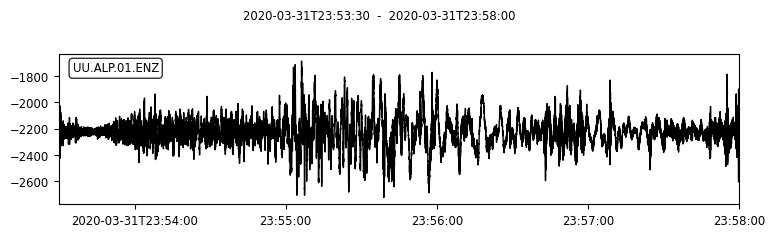

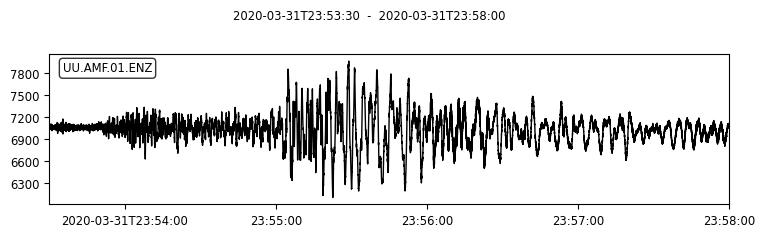

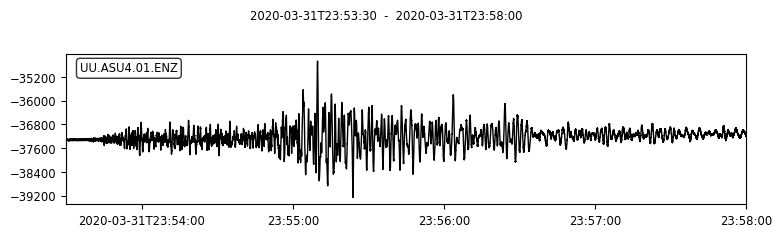

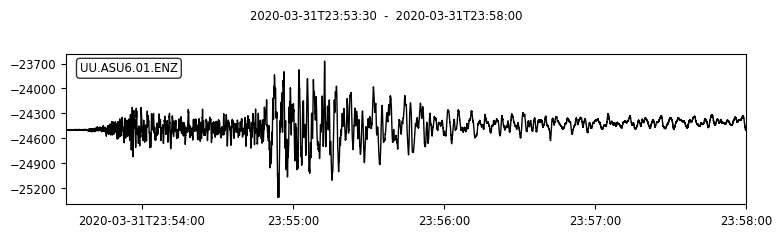

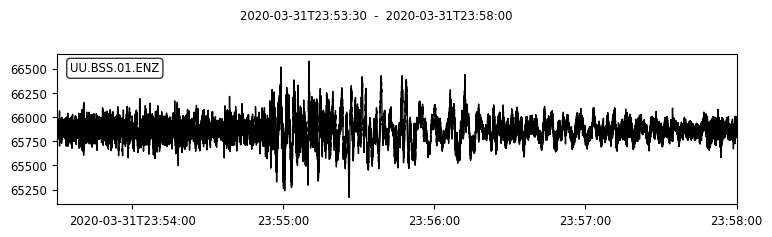

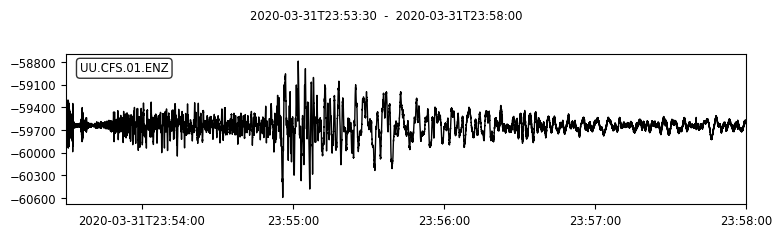

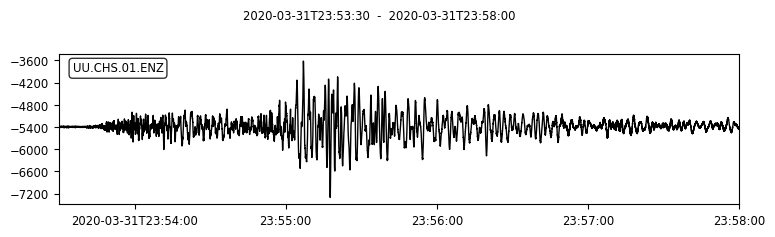

No data found for station: CTU
No data found for station: CWU


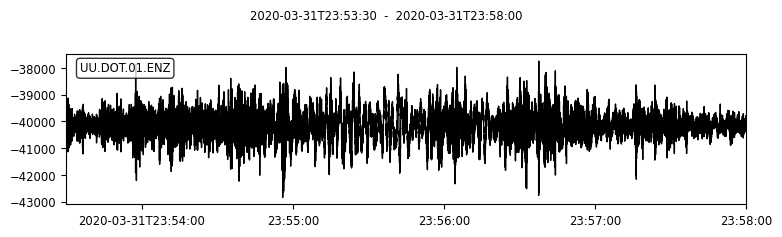

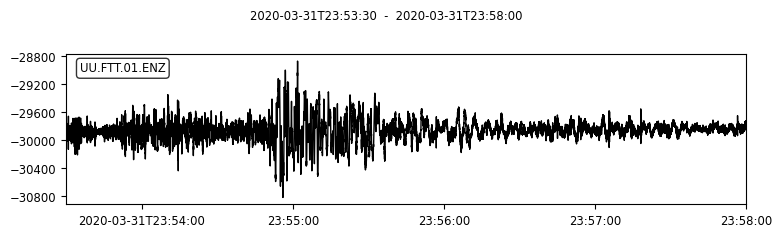

No data found for station: GMU
No data found for station: GMV


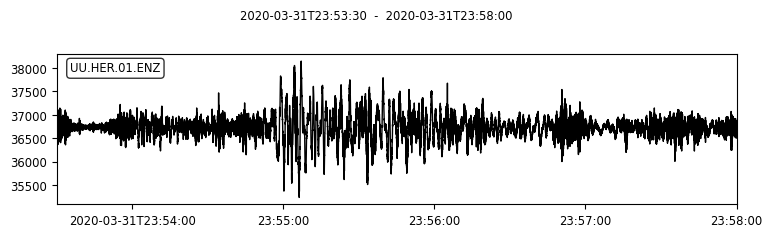

No data found for station: HFSU


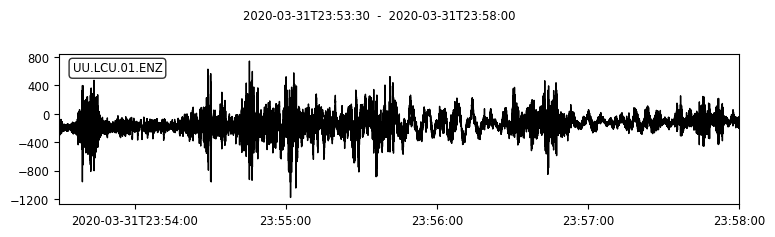

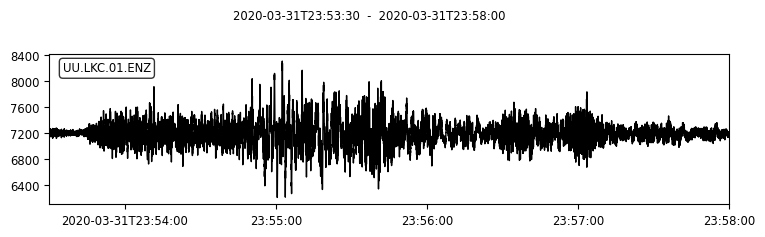

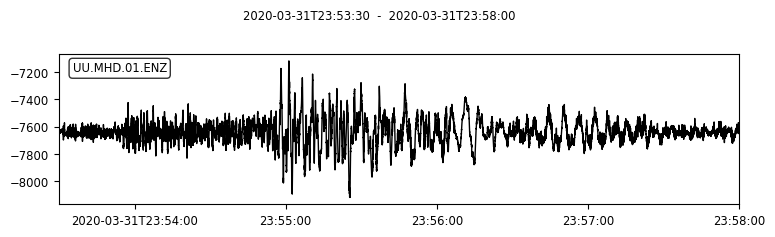

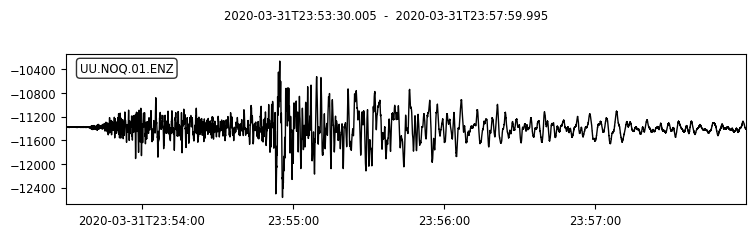

No data found for station: NOQ3
No data found for station: NOQ4
No data found for station: NOQ5
No data found for station: NOQ6


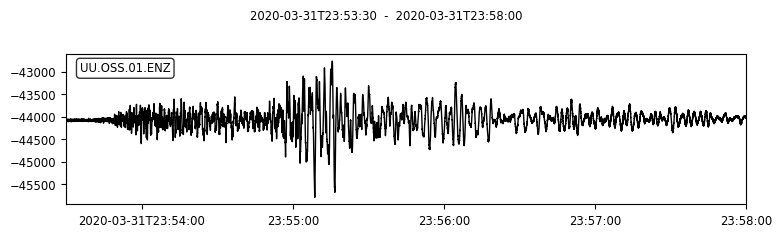

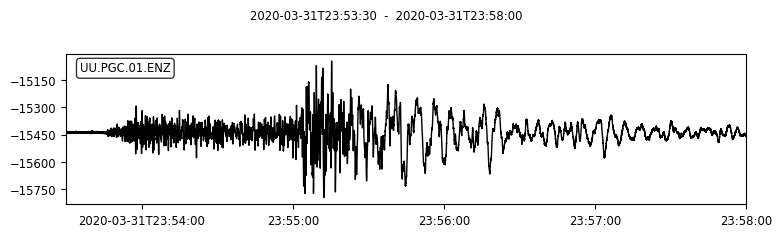

No data found for station: QBHW
No data found for station: QBNA
No data found for station: QCWC
No data found for station: QJMH
No data found for station: QKSL
No data found for station: QKSL2
No data found for station: QLIN
No data found for station: QMDS
No data found for station: QSAR2
No data found for station: QSTV
No data found for station: RIV


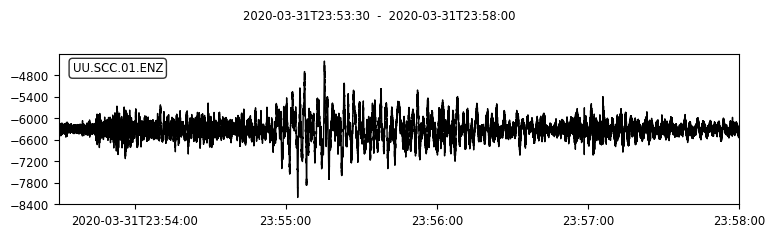

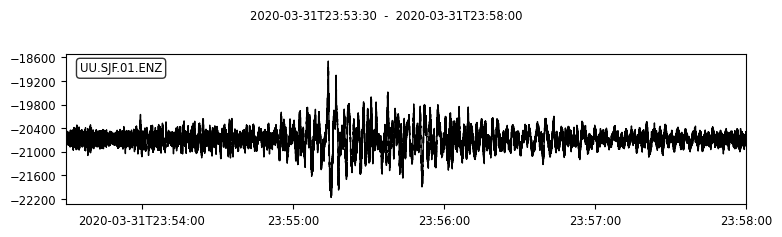

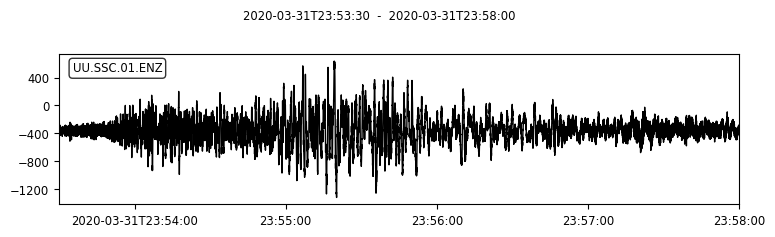

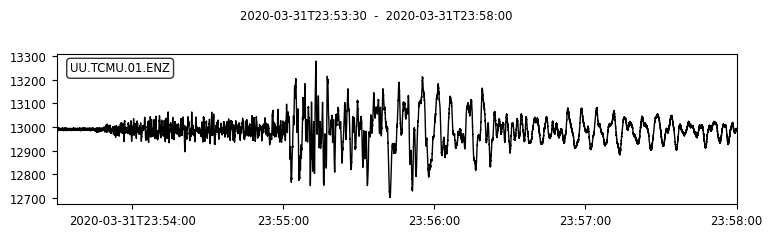

No data found for station: TCVU


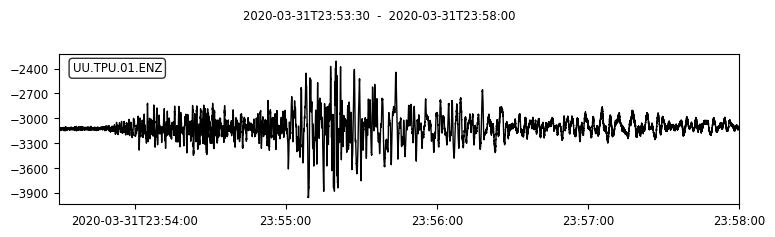

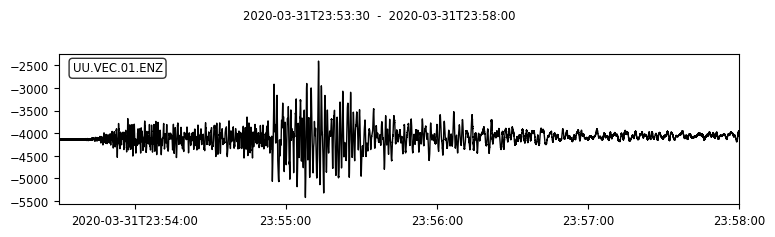

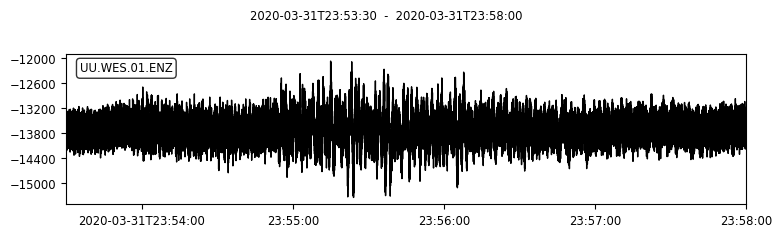

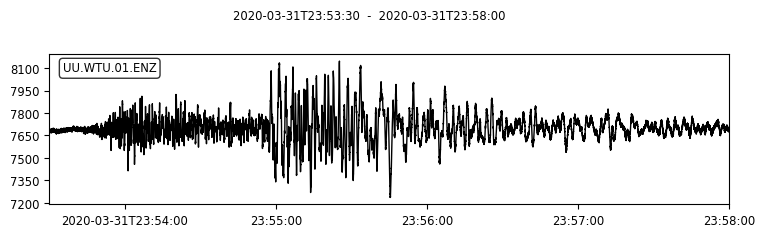

In [4]:
#Using Client function of obspy
c = Client(client)
#Getting available stations
inv = c.get_stations(network=network, station=station, location=location, minlatitude=minlat, maxlatitude=maxlat,minlongitude=minlon, maxlongitude=maxlon,level="station")
#print(inv)
#plotting the position of the stations
try:
    inv.plot(projection="local")
except:
    print("Couldn't make stations plot. Check if you have basemap or Cartopy installed")

for i in range(0,len(inv[0])):
    try:
        stream = c.get_waveforms(network,inv[0][i].code, location, channel, start, end)
        #Adding stations atributes to sac files
        saq={
            'stla':inv[0][i].latitude,
            'stlo':inv[0][i].longitude
            }
        stream[0].stats.sac=saq
        fmat = "{}.{}.{}.{}.{}.SAC".format(network, inv[0][i].code, location, channel,str(start.format_fissures()))
        #Save sac files
        stream.write(str(fmat),format="sac")
        #plot traces
        stream.plot()
    except:
        print("No data found for station: "+str(inv[0][i].code))
    


# Reading and correcting traces

In [5]:
#Reading downloaded traces
st = read("*"+str(start.format_fissures())+".SAC")
#If using seismic noise, please change to True
seismicnoise=False
if seismicnoise == False:
    #Idaho earthquake location
    evla = 44.465
    evlo = -115.118
    #Ridgecrest earthquake location
    #evla = 35.770
    #evlo = -117.599
    #Adding distance from source-receiver to trace.
    for i in range(0,len(st)):
        dec,dist,az,baz=grt(evla,evlo,st[i].stats.sac.stla,st[i].stats.sac.stlo)
        #dec,dist,az,baz=grt(44.465,-115.118,st[i].stats.sac.stla,st[i].stats.sac.stlo)
        st[i].stats.distance = dist * 1000.0
    #Removing bad or noisy traces.
    for i in ['BSS','DOT''LCU','LKC','SJF','WES']:
        for tr in st.select(station=i):
            st.remove(tr)
#Correct by trend traces
st.detrend(type='linear')
#lowering the sampling frequency for improving the code! We won't use high frequency.
st.decimate(5)

20 Trace(s) in Stream:
UU.ALP.01.ENZ  | 2020-03-31T23:53:30.000000Z - 2020-03-31T23:58:00.000000Z | 20.0 Hz, 5401 samples
UU.AMF.01.ENZ  | 2020-03-31T23:53:30.000000Z - 2020-03-31T23:58:00.000000Z | 20.0 Hz, 5401 samples
UU.ASU4.01.ENZ | 2020-03-31T23:53:30.000000Z - 2020-03-31T23:58:00.000000Z | 20.0 Hz, 5401 samples
UU.ASU6.01.ENZ | 2020-03-31T23:53:30.000000Z - 2020-03-31T23:58:00.000000Z | 20.0 Hz, 5401 samples
UU.CFS.01.ENZ  | 2020-03-31T23:53:30.000000Z - 2020-03-31T23:58:00.000000Z | 20.0 Hz, 5401 samples
UU.CHS.01.ENZ  | 2020-03-31T23:53:30.000000Z - 2020-03-31T23:58:00.000000Z | 20.0 Hz, 5401 samples
UU.DOT.01.ENZ  | 2020-03-31T23:53:30.000000Z - 2020-03-31T23:58:00.000000Z | 20.0 Hz, 5401 samples
UU.FTT.01.ENZ  | 2020-03-31T23:53:30.000000Z - 2020-03-31T23:58:00.000000Z | 20.0 Hz, 5401 samples
UU.HER.01.ENZ  | 2020-03-31T23:53:30.000000Z - 2020-03-31T23:58:00.000000Z | 20.0 Hz, 5401 samples
UU.LCU.01.ENZ  | 2020-03-31T23:53:30.000000Z - 2020-03-31T23:58:00.000000Z | 20.0 Hz, 

## Time for Capon Method!
We now have everything to run the code!

IAS Capon DOA estimation is performed at: freq 0.1 +- 0.05
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                3.08              326.31
end


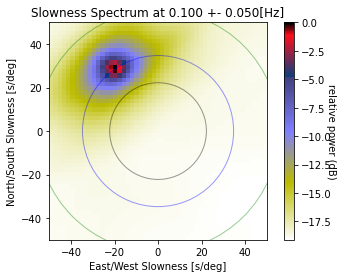

In [6]:
#Number of stations
nr = st.count()
#sampling interval
dt = st[0].stats.delta
#Obtaining relative position of stations
rx,ry = metric(st)
#Number of samples in windows for analysis
nsamp = 2000
#Minimum slowness
smin = -50.0
#Máximum Slowness
smax = 50.0
#Slowness increment. Note: 5 - 2 are optimum values. Less that 3 will make better images but the program will be running a while.
#More than 5 will make really bad precition.
sinc = 2
#Frequency at the method will run. It must be an integer. The frequency value is calculated by (cap_find/(nsamp*dt)
cap_find = 10
#add and substract the cap_find frequency. (cap_fave/(nsamp*dt) 
cap_fave = 5
#Weigths the diagonal of the capon matrix. You can try using 100, 10000 for more robust results
dl = 1
#IAS_CAPON
fk,sxopt,syopt,vel,rp,baz,maa,pwe = IAS_Capon(nsamp,nr,rx,ry,st,smin,smax,sinc,cap_find,cap_fave,dt,dl,overlap=True,taper=True)
#Print stats
a=print_stats(fk,smin,smax,sinc,threshold=0.2)
#Plot_Results. If you want to save the image, change saveimg to True
Plot_FK_Results(fk,cap_find,cap_fave,nsamp,dt,smin,smax,5,3.2,2,saveimg=False)

# Dispertion curves
now, we have to run many times the capon method and save the arrival information to construct a dispertion curve.

IAS Capon DOA estimation is performed at: freq 0.06 +- 0.04
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                3.08              326.31
end


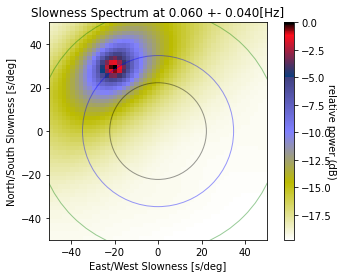

IAS Capon DOA estimation is performed at: freq 0.08 +- 0.04
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                3.08              326.31
end


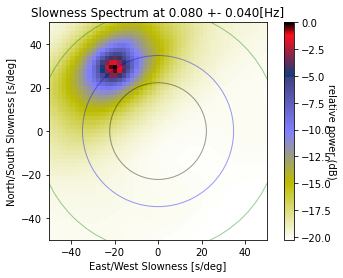

IAS Capon DOA estimation is performed at: freq 0.1 +- 0.04
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                3.08              326.31
end


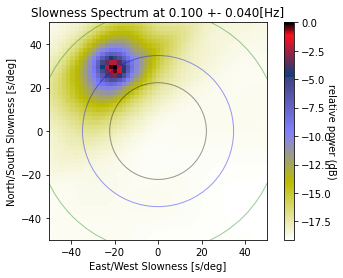

IAS Capon DOA estimation is performed at: freq 0.12 +- 0.04
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                2.99              323.75
end


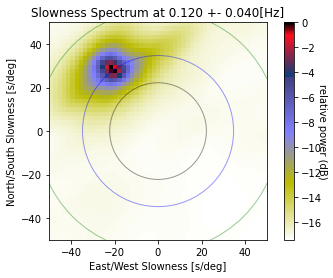

IAS Capon DOA estimation is performed at: freq 0.14 +- 0.04
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                3.23              324.46
end


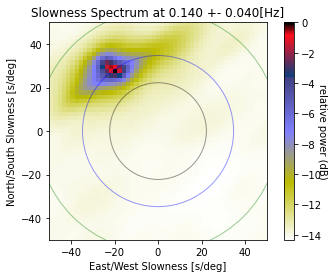

IAS Capon DOA estimation is performed at: freq 0.16 +- 0.04
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                3.23              324.46
end


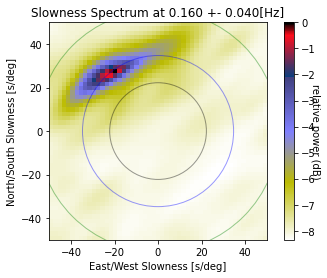

IAS Capon DOA estimation is performed at: freq 0.18 +- 0.04
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                2.89              308.66
       -2.12                2.89                8.97
end


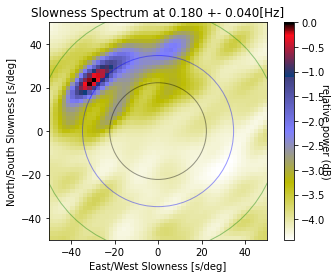

IAS Capon DOA estimation is performed at: freq 0.2 +- 0.04
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                2.78              306.87
       -1.87                3.64              328.39
       -1.95                3.02              337.62
end


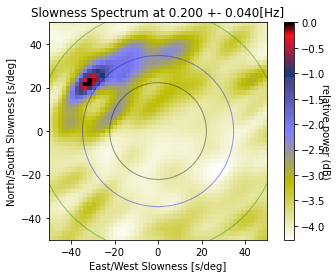

IAS Capon DOA estimation is performed at: freq 0.22 +- 0.04
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                2.78              306.87
       -0.18                3.64              328.39
       -1.43                4.75              289.98
end


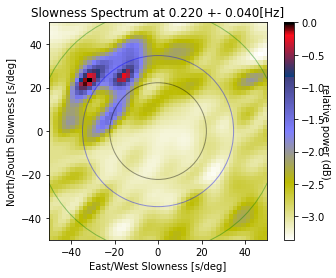

IAS Capon DOA estimation is performed at: freq 0.24 +- 0.04
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                3.64              328.39
       -0.14                2.67              305.22
       -1.24                4.88              285.26
end


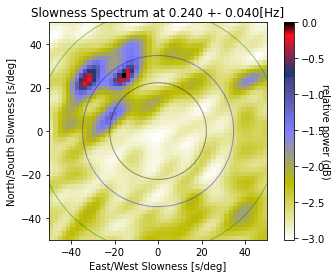

IAS Capon DOA estimation is performed at: freq 0.26 +- 0.04
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                3.64              328.39
       -0.94                2.75              302.91
end


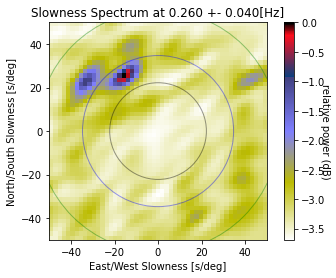

IAS Capon DOA estimation is performed at: freq 0.28 +- 0.04
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                3.64              328.39
end


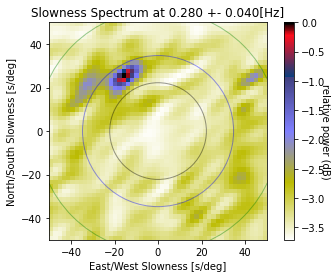

IAS Capon DOA estimation is performed at: freq 0.3 +- 0.04
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                3.77              331.70
end


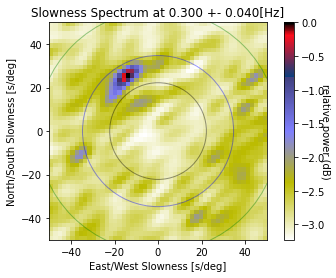

IAS Capon DOA estimation is performed at: freq 0.32 +- 0.04
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                3.77              331.70
       -1.24                2.93              251.57
       -1.29                2.49              153.43
       -1.31                3.88              114.78
end


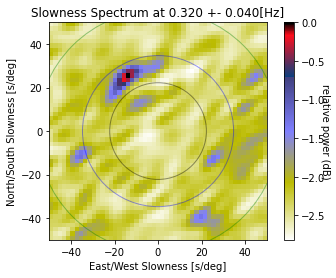

IAS Capon DOA estimation is performed at: freq 0.34 +- 0.04
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                3.85              326.31
       -0.86                3.77              118.30
       -1.06                3.70              356.19
       -1.11                2.10               60.52
       -1.16                2.49              153.43
       -1.20                6.90              330.26
       -1.22                2.93              251.57
end


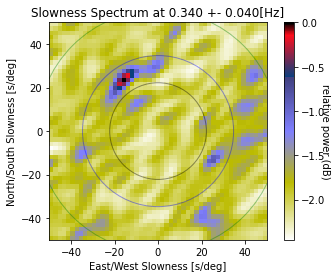

IAS Capon DOA estimation is performed at: freq 0.36 +- 0.04
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                3.85              326.31
       -0.52                3.77              118.30
       -0.81                3.71                0.00
       -0.83                2.75               98.53
       -0.86                6.90              330.26
       -0.87                1.82              218.37
       -0.88                2.38                9.87
       -0.88                5.45               78.69
       -0.88                2.22               92.29
       -0.90                2.35              152.35
       -0.91                2.93              251.57
       -0.96                2.25              211.76
       -0.96                2.20               56.31
       -1.02                4.40              288.43
       -1.05                2.

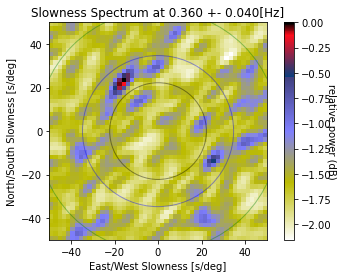

IAS Capon DOA estimation is performed at: freq 0.38 +- 0.04
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                3.85              326.31
       -0.66                4.00              120.26
       -0.75                5.45               78.69
       -0.84                2.75               98.53
       -0.91                2.20               56.31
       -0.95                1.82              218.37
       -0.98                3.34              147.26
       -1.03                2.62               70.71
       -1.04                4.40              288.43
       -1.05                6.51              339.44
       -1.06                2.22              355.43
end


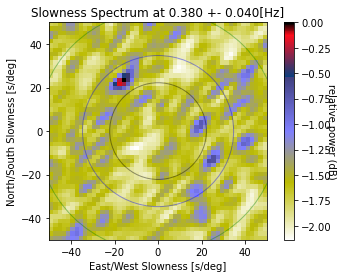

IAS Capon DOA estimation is performed at: freq 0.4 +- 0.04
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                3.85              326.31
       -0.43                6.18               90.00
       -0.48                2.25              223.36
       -0.62                2.75               98.53
       -0.62                2.22              355.43
       -0.63                2.79               72.47
       -0.63                3.52              145.30
       -0.63                2.34               14.62
       -0.63                7.12              320.19
       -0.65                2.25               58.24
       -0.70                4.91              315.00
       -0.73                3.52               55.30
       -0.73                4.17              282.99
       -0.74                9.14                9.46
       -0.75                2.2

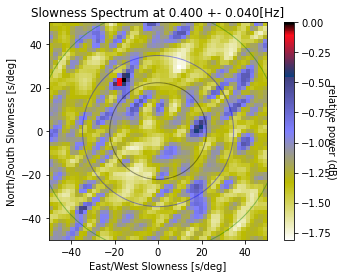

IAS Capon DOA estimation is performed at: freq 0.42 +- 0.04
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                3.91              320.71
       -0.10                2.25              223.36
       -0.13                6.18               90.00
       -0.14                2.18              329.42
       -0.16                3.39              142.43
       -0.16                2.22              355.43
       -0.26                2.22              267.71
       -0.27                2.34               14.62
       -0.28                1.91               49.18
       -0.33                2.44               61.19
       -0.35                7.86              315.00
       -0.41                9.53              149.04
       -0.41                2.01              319.40
       -0.41                2.71               46.97
       -0.41                2.

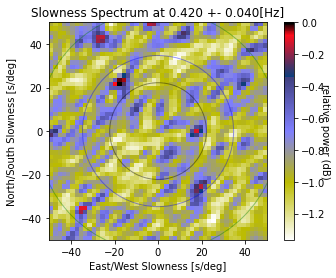

IAS Capon DOA estimation is performed at: freq 0.44 +- 0.04
Diagonal Loading On!
---------------------------
--- Arrival Information ---
---------------------------

normalized power (dB)    velocity (km/s)    backazimuth (deg)
        0.00                2.25              223.36
       -0.07                3.42              137.49
       -0.12                3.74              317.73
       -0.20                2.25              328.24
       -0.21                2.22              267.71
       -0.22                2.22              357.71
       -0.23                5.56              143.13
       -0.23                7.12              320.19
       -0.24                2.44               61.19
       -0.25                1.86               50.44
       -0.30                2.31               16.93
       -0.30                3.34               57.26
       -0.31                2.93              288.43
       -0.35                2.17              128.66
       -0.36                3.

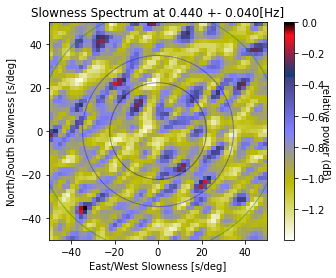

In [7]:
#Making lists to save frequency, velocity and backazimuth
disp_freq=[]
disp_vel=[]
disp_bak=[]
#Times to run the method
j=20
sinc=2
for i in range(0,j):
    #Every loop will add 2 points.
    cap_find = 6+2*i
    cap_fave = 4
    dl = 1
    #Runing IAS_Capon
    fk,sxopt,syopt,vel,rp,baz,maa,pwe = IAS_Capon(nsamp,nr,rx,ry,st,smin,smax,sinc,cap_find,cap_fave,dt,dl,overlap=True,taper=True)
    a=print_stats(fk,smin,smax,sinc,threshold=0.5,print_results=True)
    #Change saveimg to True if you want to save images
    Plot_FK_Results(fk,cap_find,cap_fave,nsamp,dt,smin,smax,5,3.2,2,saveimg=False)
    #Saving frequency to make dispersion curves
    disp_freq.append(cap_find/(nsamp*dt))
    #If the result is inf (Method doesn't work properly, check that there are no repeated traces) or is higher than 5, add the second value.
    if a[0][1] == ' inf' or a[0][1] > 5:
        disp_vel.append(a[1][1])
        disp_bak.append(a[1][2])
    else:
        disp_vel.append(a[0][1])
        disp_bak.append(a[0][2])

# Plot Dispersion Curves
We can use the dispersion curves to undestand more the structure of the subsurface, superior modes of surface waves and check the sources with seismic noise.

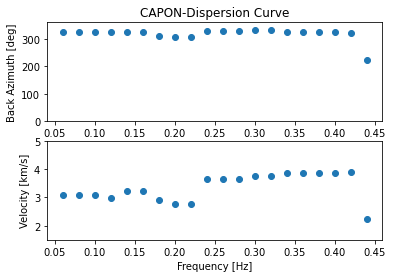

In [8]:
fig, (ax1,ax2)= plt.subplots(2)
ax1.plot(disp_freq,disp_bak,'o')
ax1.set_title('CAPON-Dispersion Curve')
ax1.set_ylabel('Back Azimuth [deg]')
ax1.set_ylim([0,360])
ax2.plot(disp_freq,disp_vel,'o')
ax2.set_ylim([1.5,5])
ax2.set_ylabel('Velocity [km/s]')
ax2.set_xlabel('Frequency [Hz]')
plt.show()

# Plot Record Section
With this section, we can filter our traces and check that the Capon method is giving us good results. In this example I use a wavelet of 12 to 8 seconds. You can try some other filters. Note: with seismic noise this cannot be done because we don't know where the source is!

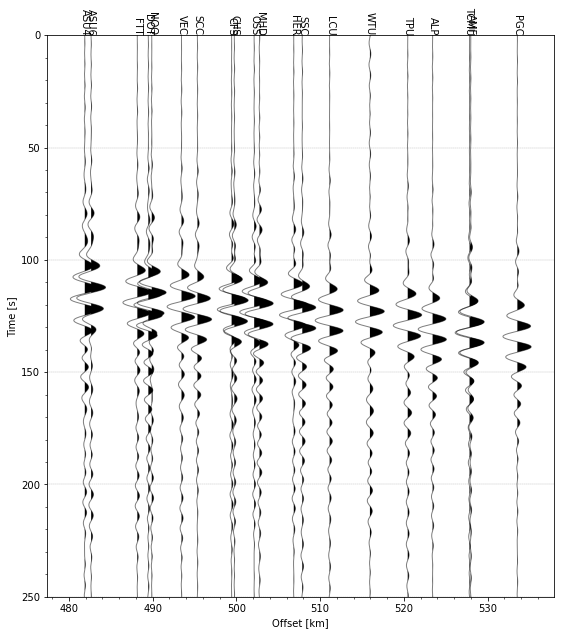

In [9]:
st1=st.copy()
fmin=0.0833
fmax=0.125
st1.filter(type="bandpass",freqmin=fmin,freqmax=fmax,zerophase=True)
fig = plt.figure(figsize=([8,10]))
st1.plot(type='section', recordlength=250, time_down=True, linewidth=1,fillcolors=("black","None"), grid_linewidth=.25, fig=fig)
ax = fig.axes[0]
transform = blended_transform_factory(ax.transData, ax.transAxes)
for tr in st:
    ax.text(tr.stats.distance / 1e3, 1.0, tr.stats.station, rotation=270, va="bottom", ha="center", transform=transform, zorder=10)

Remember to check the distance between the stations to check the minimun wavelength we can observe!

# Reference

Gal, M., Reading, A., Ellingsen, S., Koper, K., Gibbons, S., & Näsholm, S. (2014). Improved implementation of the fk and Capon methods for array analysis of seismic noise. Geophysical Journal International, 198(2), 1045-1054. https://doi.org/10.1093/gji/ggu183